In [37]:
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss, roc_auc_score
from scipy.sparse import hstack

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime as dt
import warnings
import scipy
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
!pip install seaborn -q

Выполним предобработку данных и EDA аналогично ДЗ 1 (только дропать будем уже другие столбцы, согласно условию)

In [5]:
np.random.seed(10)

In [6]:
path_to_data = '../input/clicks/data.csv'

In [7]:
data = pd.read_csv(path_to_data)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [8]:
data.describe()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582140e+07,1.582140e+07,1.582140e+07,1.582147e+07,1.580173e+07,1.580173e+07,1.580173e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,4.610505e+18,6.238540e-01,1.840605e+00,4.346986e+00,6.571314e+05,1.969248e-01,7.440764e-01,-3.979590e+00,2.605069e+06,1.415899e+00,5.485722e-01,-3.968883e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,2.663858e+18,9.249152e+00,1.530005e+00,4.317701e+00,2.606008e+06,2.733440e+00,1.670358e+01,1.143982e+00,5.230253e+06,8.689053e+00,1.419136e+01,1.186403e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,1.116911e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.763740e-02,-8.588970e+00,0.000000e+00,0.000000e+00,-6.983897e-02,-9.562188e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,2.297977e+18,0.000000e+00,1.000000e+00,0.000000e+00,7.300000e+01,5.000000e-03,1.643856e-02,-4.515871e+00,9.900000e+01,4.000000e-03,1.615219e-02,-4.529519e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,4.614236e+18,0.000000e+00,2.000000e+00,4.000000e+00,3.030000e+02,1.000000e-02,3.539307e-02,-3.921164e+00,4.600000e+02,1.400000e-02,3.556666e-02,-3.928674e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,6.914243e+18,0.000000e+00,3.000000e+00,7.000000e+00,7.200000e+02,3.000000e-02,8.022935e-02,-3.421280e+00,1.236000e+03,5.000000e-02,7.546751e-02,-3.390867e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,9.223371e+18,8.290000e+02,1.000000e+01,1.600000e+01,1.146423e+07,1.000000e+02,6.910888e+02,3.149981e-01,1.462360e+07,1.000000e+02,6.910885e+02,4.756181e-01,1.0,1.000000e+00


Как видим, impressions состоит только из одних единиц, т.к. этот признак в себе не несет информации, можем его отбросить

In [9]:
def drop_unnecessary_data(data: pd.DataFrame) -> pd.DataFrame:
    return data.drop(['oaid_hash', 
                     'campaign_clicks', 
                      'impressions'], axis=1)

In [10]:
def plot_features(features: pd.DataFrame):
    fig, axs = plt.subplots(features.shape[1] // 2, 2, figsize=(12,9))
    for i in tqdm(range(features.shape[1])):
        axs[i // 2, i % 2].hist(features.iloc[:, i])
        axs[i // 2, i % 2].set_title(str(features.columns[i]))
    plt.tight_layout()
    plt.show()

In [11]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    cleaned_data = drop_unnecessary_data(data)
    cleaned_data.date_time = pd.to_datetime(cleaned_data.date_time)
    return cleaned_data

In [12]:
def analysis(data: pd.DataFrame):
    cleaned_data = clean_data(data)
    print(f'Размер датасета: {cleaned_data.shape}')
    print(f'NaN значений в датасете: {cleaned_data.isna().values.sum()}')
    print(f'Уникальных значений в столбцах: \n{cleaned_data.nunique()}')
    plot_features(cleaned_data.iloc[:, 1:-1])
    print(f'Матрица корреляции:')

Размер датасета: (15821472, 14)
NaN значений в датасете: 59439
Уникальных значений в столбцах: 
date_time       604712
zone_id           3444
banner_id         1633
os_id               11
country_id          17
banner_id0      946937
rate0              428
g0            15147522
coeff_sum0     5262825
banner_id1     3160859
rate1              845
g1            15169168
coeff_sum1     5660517
clicks               2
dtype: int64


100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


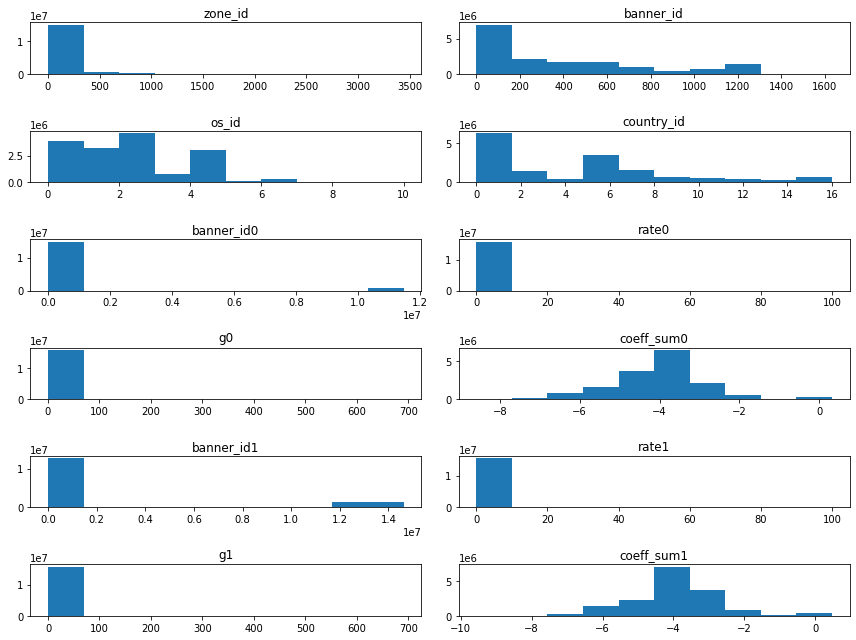

Матрица корреляции:


In [13]:
analysis(data)

Можем сделать следующие выводы:

* В датасете на этот раз присутствуют `NaN` значения (однако в масштабе всего датасета их не столь много)

* Много категориальных признаков для которых потребуется `OneHotEncoding`


In [14]:
cleaned_data = clean_data(data).dropna()
cleaned_data.shape

(15801728, 14)


Применим  `OneHotEncoding` , после чего поделим `X` и `y` на `train` и `test` (последний день)

In [15]:
def get_X_y(data: pd.DataFrame) -> (pd.DataFrame, pd.Series):
    X = data.drop(columns=['clicks'])
    y = data.clicks
    return X, y

In [16]:
def train_test_split(data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
   
    last_year = data.date_time.max().year
    last_month = data.date_time.max().month
    last_day = data.date_time.max().day
    latest_data = pd.Timestamp(last_year, last_month, last_day)
    test_data = data[data.date_time >= latest_data]
    train_data = data[data.date_time < latest_data]
    train_data = train_data.drop(columns=['date_time'])
    test_data = test_data.drop(columns=['date_time'])
    
    return train_data, test_data

In [17]:
def feature_engineering(data):    
    train_data, test_data = train_test_split(data)
    train_data = train_data[train_data['banner_id0'] == train_data['banner_id']].drop(columns=['banner_id1', 'banner_id0'])
    X_train, y_train = get_X_y(train_data)
    
    test_data = test_data[test_data['banner_id0'] == test_data['banner_id']]
    #policy 0
    test_pi_0 = test_data.copy()
    test_pi_0 = test_pi_0
    #policy 1
    test_pi_1 = test_data.copy()
    test_pi_1['banner_id'] = test_pi_1['banner_id1']
    test_pi_1 = test_pi_1
    
    test_cips = test_data.copy()
    
    cat_features = ['zone_id', 'os_id', 'country_id', 'banner_id']
    
    test_pi_0.drop(columns=['banner_id0', 'banner_id1'], inplace=True)
    test_pi_1.drop(columns=['banner_id0', 'banner_id1'], inplace=True)
    test_data.drop(columns=['banner_id0', 'banner_id1'], inplace=True)
    test_cips.drop(columns=['banner_id0', 'banner_id1'], inplace=True)
    
    X_test, y_test = get_X_y(test_data)
    X_test_pi_0, y_test_pi_0 = get_X_y(test_pi_0)
    X_test_pi_1, y_test_pi_1 = get_X_y(test_pi_1)
    X_test_cips, y_test_cips = get_X_y(test_cips)
    
    del test_data
    del test_pi_0
    del test_pi_1
    del test_cips
    
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
    
    X_train_enc = ohe.fit_transform(X_train[cat_features])
    X_train.drop(columns=cat_features, inplace=True)
    X_train = hstack([X_train_enc, X_train.to_numpy()])

    X_test_pi_0_enc = ohe.transform(X_test_pi_0[cat_features])
    X_test_pi_0.drop(columns=cat_features, inplace=True)
    X_test_pi_0 = hstack([X_test_pi_0_enc, X_test_pi_0.to_numpy()])
    
    X_test_pi_1_enc = ohe.transform(X_test_pi_1[cat_features])
    X_test_pi_1.drop(columns=cat_features, inplace=True)
    X_test_pi_1 = hstack([X_test_pi_1_enc, X_test_pi_1.to_numpy()])
    
    return {'train' : (X_train, y_train), 'test_pi_0' : (X_test_pi_0, y_test_pi_0), 
            'test_pi_1' : (X_test_pi_1, y_test_pi_1), 'test_cips' : (X_test_cips, y_test_cips)}

Кроме деления на `train` и `test` по дню, также оставим `test` для $\pi_0$ и $\pi_1$, т.к. они различаются по `banner_id`

In [18]:
train_test_data = feature_engineering(cleaned_data)
X_train, y_train = train_test_data['train']
X_test_pi_0, y_test_pi_0 = train_test_data['test_pi_0']
X_test_pi_1, y_test_pi_1 = train_test_data['test_pi_1']
X_test_cips, y_test_cips = train_test_data['test_cips']

In [19]:
print(f'X_train : {X_train.shape}')
print(f'X_test_pi_0 : {X_test_pi_0.shape}')

X_train : (12041815, 4772)
X_test_pi_0 : (1885670, 4772)


Будем использовать как и в 1-ой ДЗ логистическую регрессию с liblinear optimizer и $L2$ регуляризацией при $C = 0.01$

In [20]:
def create_model(C=0.01):
    return LogisticRegression(solver='liblinear', 
                              random_state=10,
                              penalty='l2',
                              C=C)

In [21]:
log_reg_model = create_model()
log_reg_model.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=10, solver='liblinear')

In [22]:
model_pred = log_reg_model.predict_proba(X_test_pi_0)

In [23]:
def get_stats(model_pred: np.array, y_test: np.array):
    auc_model = roc_auc_score(y_test, model_pred[:, 1])
    log_loss_model = log_loss(y_test, model_pred)
    print(f'Logistic regression model: ')
    print(f'----------------')
    print(f'Log Loss : {log_loss_model}')
    print(f'ROC AUC : {auc_model}')

In [24]:
get_stats(model_pred, y_test_pi_0)

Logistic regression model: 
----------------
Log Loss : 0.13308410922843322
ROC AUC : 0.7966003552348595


In [25]:
def get_logit(prob: float):
    return np.log(prob / (1 - prob))

У нас имеются две независимые случайные величины, которые распределены нормально $X_0 \sim N( coef_0, g_0^2)$ и $X_1 \sim N(coef_1, g_1^2)$. Их разница $X = X_1 - X_0$ также распределена нормально $X \sim N(coef_1 - coef_0, g_1^2 + g_0^2)$. Для определения $P(X_1 > X_2)$ воспользуемся функцией распределения нормального распределения $$F(x) = \Phi (\frac{x - \mu}{\sigma}) = \Phi\big(\frac{coef_0 - coef_1}{\sqrt{g_0^2+g_1^2}}\big)$$

In [38]:
def get_cdf(coef_0, coef_1, g_0, g_1):
    mu = coef_0 - coef_1
    std = np.sqrt(g_0 ** 2 + g_1 ** 2)
    return scipy.stats.norm.cdf(mu / std)

In [39]:
pi_0 = get_cdf(X_test_cips['coeff_sum0'], X_test_cips['coeff_sum1'], X_test_cips['g0'], X_test_cips['g1'])

In [34]:
new_coeff_sum_0 = get_logit(log_reg_model.predict_proba(X_test_pi_0)[:, 1])
new_coeff_sum_1 = get_logit(log_reg_model.predict_proba(X_test_pi_1)[:, 1])

In [40]:
pi_1 = get_cdf(new_coeff_sum_0, new_coeff_sum_1, X_test_cips['g0'], X_test_cips['g1'])

In [42]:
def clipped_ips(pi_0, pi_1, rewards, lambda_val=10, eps=1e-12):
    return np.sum(rewards * np.minimum(pi_1 / (pi_0 + eps), lambda_val)) / pi_0.shape[0]

In [43]:
clipped_ips = clipped_ips(pi_0, pi_1, y_test_cips)

In [50]:
print(f'V_cips = {clipped_ips}')

V_cips = 0.07174851197032835
